In [1041]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO   
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
import pydotplus
import numpy

In [1042]:
df = pd.read_csv('./Admission_Predict_Ver1.1.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


## Design a set of rules to create admit column

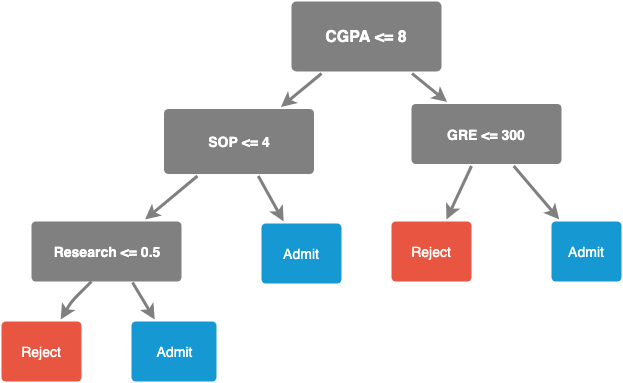

In [1043]:
def review(df):
    if (df['CGPA'] <= 8):
        if (df['SOP'] <= 4):
            if (df['Research'] <= 0.5):
                return 0
            else:
                return 1
        else:
            return 1
    else:
        if (df['GRE Score'] <= 300):
            return 0
        else:
            return 1
df['Admit'] = df.apply(review, axis =1)
df['Admit'].value_counts()


1    420
0     80
Name: Admit, dtype: int64

## Drop useless attributes

In [1044]:
df = df.drop('Serial No.', axis = 1)
df = df.drop('TOEFL Score', axis = 1)
df = df.drop('University Rating', axis = 1)
df = df.drop('LOR ', axis = 1)
df = df.drop('Chance of Admit ', axis = 1)


In [1045]:
df.head(10)

,GRE Score,SOP,CGPA,Research,Admit
0,337,4.5,9.65,1,1
1,324,4.0,8.87,1,1
2,316,3.0,8.00,1,1
3,322,3.5,8.67,1,1
4,314,2.0,8.21,0,1
5,330,4.5,9.34,1,1
6,321,3.0,8.20,1,1
7,308,3.0,7.90,0,0
8,302,2.0,8.00,0,0
9,323,3.5,8.60,0,1


## Split attributes and label

In [1046]:
x = df.drop('Admit', axis = 1)
y = df['Admit']

## Create decision tree

In [1047]:
dtree = DecisionTreeClassifier(max_depth = 3)
dtree.fit(x, y)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(x),
                class_names=['Reject','Admit'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("tree.pdf")

True

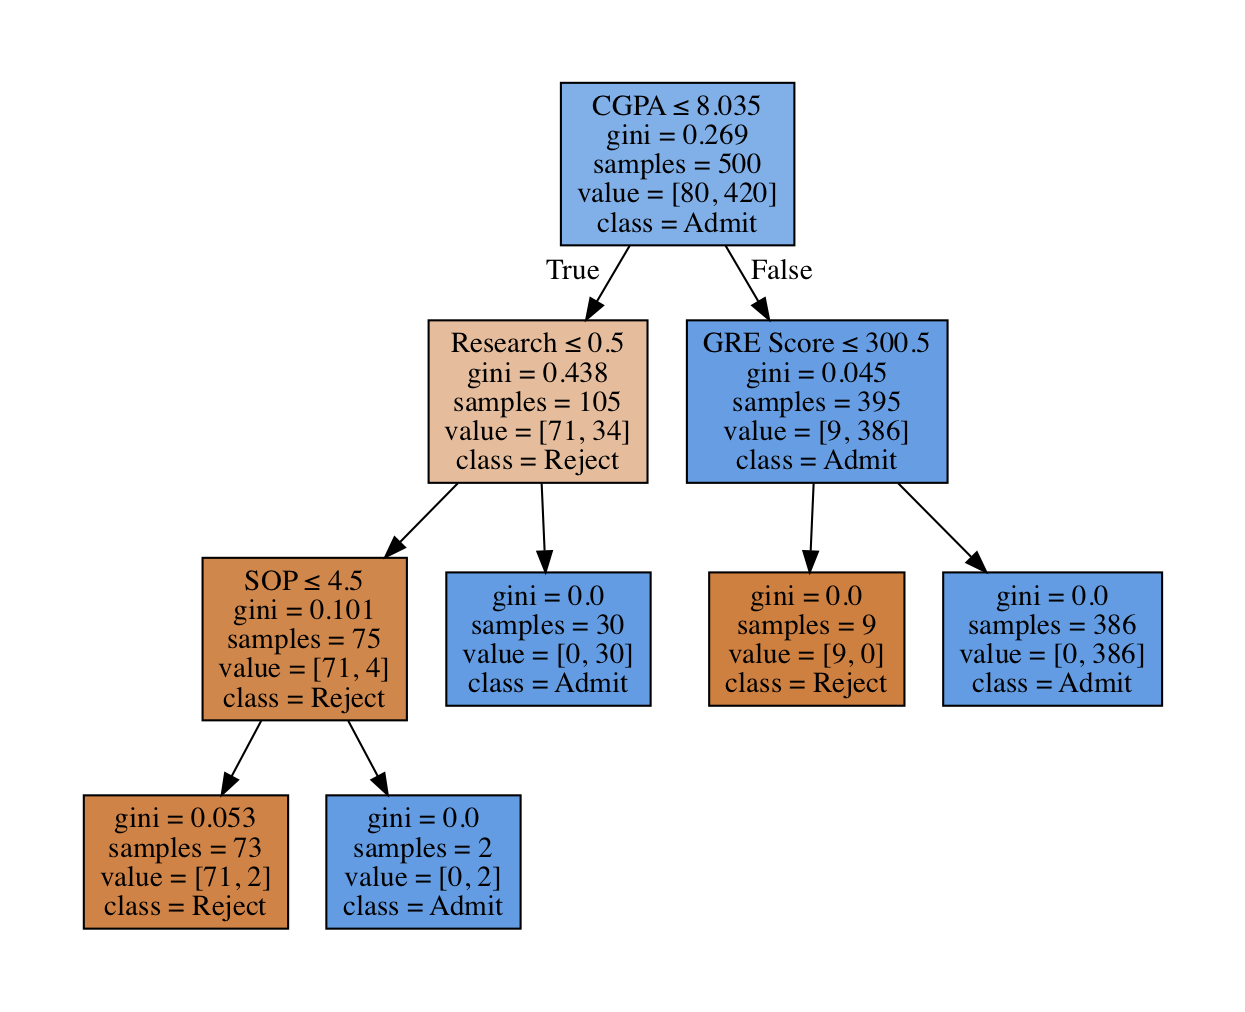

# Compare my set of rules and the decision tree created by usnig sklearn 

## 1. Look over the structure of two trees

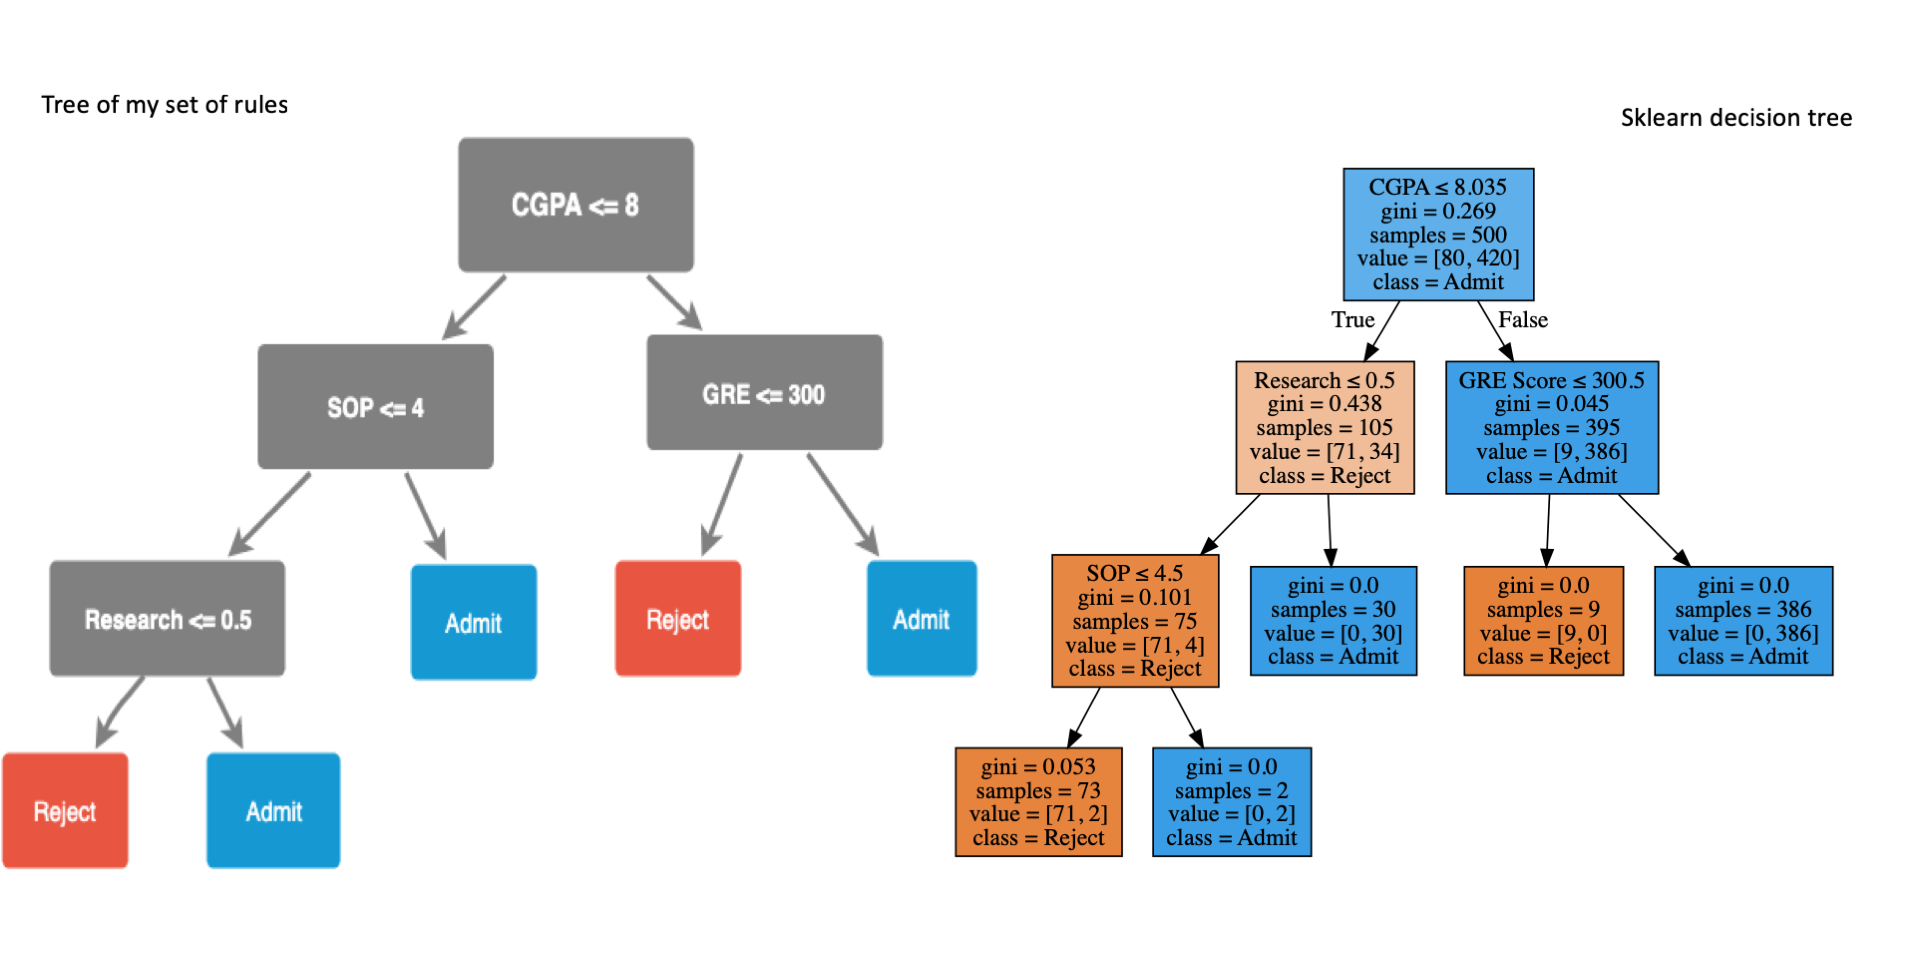

###  right hand side  :
The order of attributes are same from top to buttom.
###  left hand side :
SOP and Research are in reverse order.

### The observations above will be discussed below

## 2. Find out useful informations like gini index, value, samples amount on my set of rules

###  Caculate gini at the block (CGPA <= 8)  and it's children

In [1070]:
df['Admit'].value_counts()

1    420
0     80
Name: Admit, dtype: int64

In [1050]:
df[ df['CGPA'] <= 8].count()

GRE Score    93
SOP          93
CGPA         93
Research     93
Admit        93
dtype: int64

In [1067]:
1-(((93/500)**2) + ((407/500)**2))

0.3028080000000001

Gini(parent) = 0.302

In [1052]:
df_left = df[ df['CGPA'] <= 8]
df_left['Admit'].value_counts()

0    66
1    27
Name: Admit, dtype: int64

In [1053]:
df_right = df[ df['CGPA'] > 8]
df_right['Admit'].value_counts()

1    393
0     14
Name: Admit, dtype: int64

In [1054]:
1-(((27/93)**2) + (66/93)**2)

0.4120707596253901

gini(left) = 0.412

In [1055]:
1-(((393/407)**2) + (14/407)**2)

0.06642961925517199

gini(right) = 0.066

### Caculate gini at the block (SOP <= 4) and it's children

In [1057]:
df_left.count()

GRE Score    93
SOP          93
CGPA         93
Research     93
Admit        93
dtype: int64

In [1058]:
df_left[ df_left['SOP'] <=4 ].count()

GRE Score    91
SOP          91
CGPA         91
Research     91
Admit        91
dtype: int64

In [1059]:
df_L = df_left[ df_left['SOP'] <=4]
df_L['Admit'].value_counts()

0    66
1    25
Name: Admit, dtype: int64

In [1060]:
df_R = df_left[ df_left['SOP'] >4 ]
df_R['Admit'].value_counts()

1    2
Name: Admit, dtype: int64

In [1061]:
1-(((66/91)**2) + (25/91)**2)

0.3985025963047941

gini(left) = 0.399

In [1062]:
1-(((0/2)**2) + (2/2)**2)

0.0

gini(right) = 0.0

## 3. Compare two trees again with extra informations we already got.

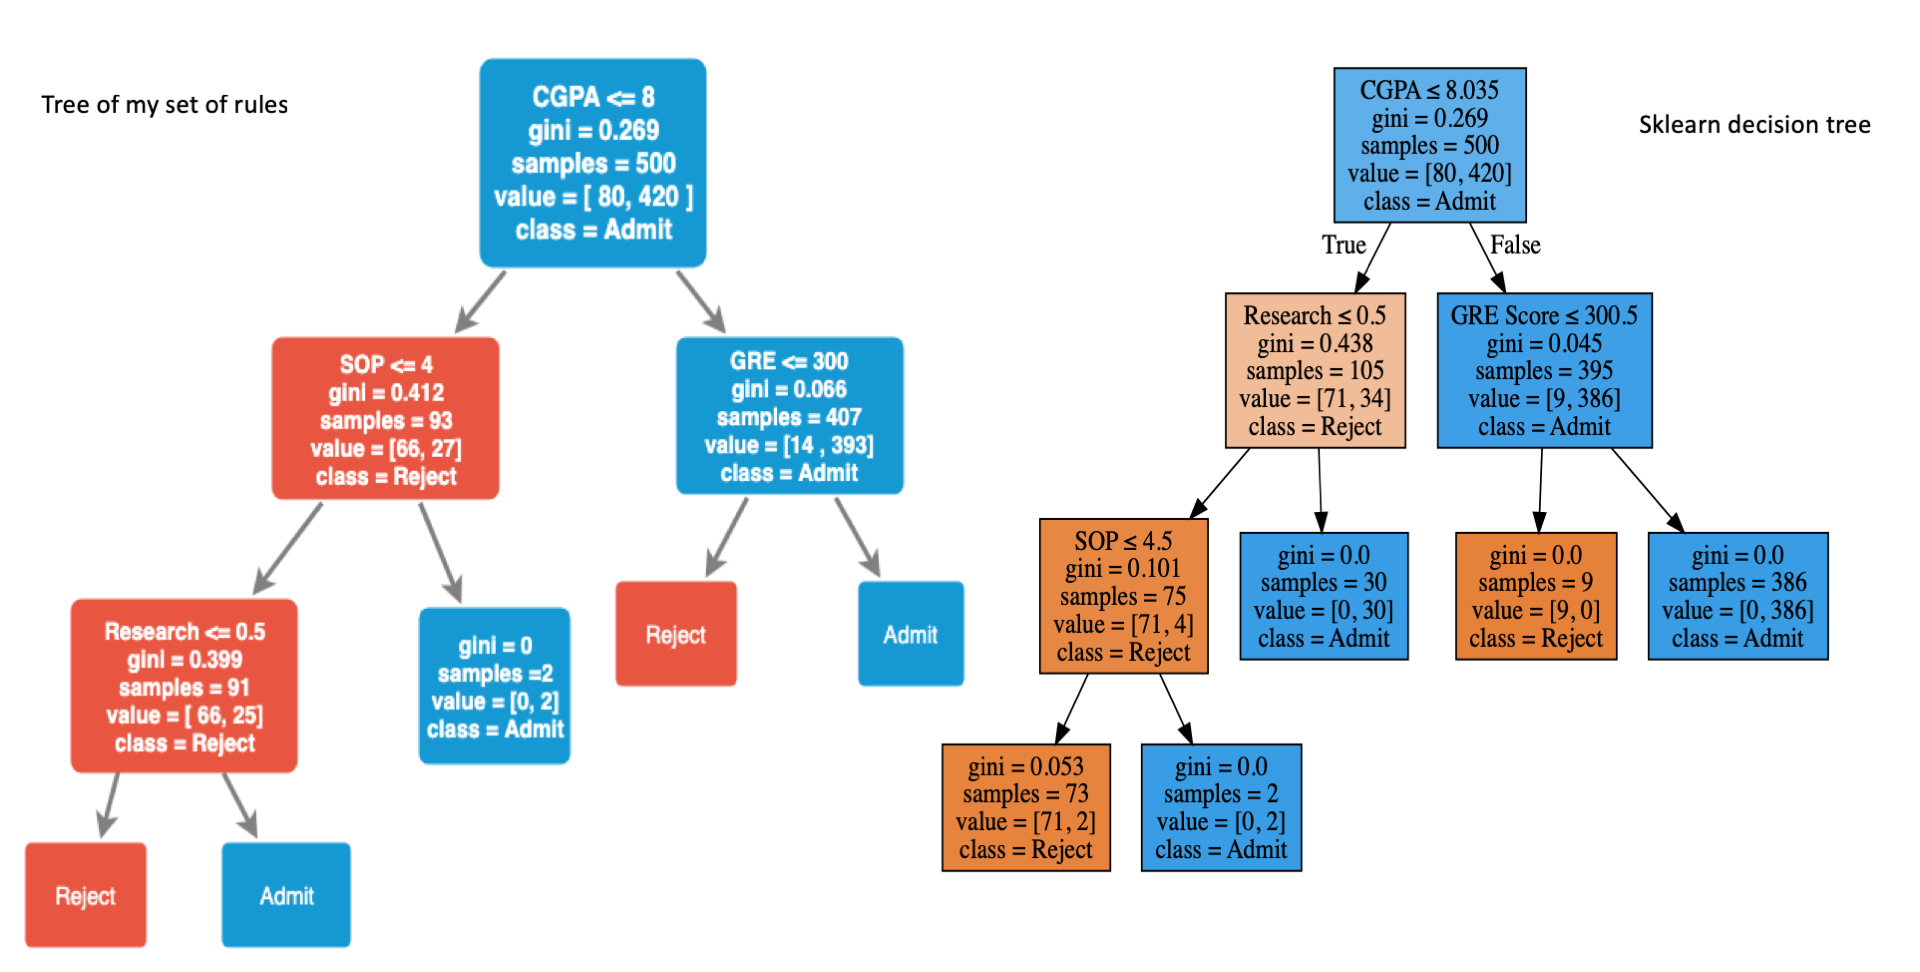

### Calculate information gain from chosing SOP and Research as attribute in depth = 2 at left side

In [1063]:
0.412-(((0.398)*(91) + (0)*(2))/93)

0.02255913978494617

IG(SOP<=4) = 0.022

In [1005]:
0.438-(((0.101)*(75) + (0)*(30))/105)

0.3658571428571429

IG(Research<=0.5) = 0.366

### As you can see, information gain from (Research<=0.5)is greatly less than (SOP<=4).


### It means choosing (Research<=0.5) at this step is much more better.

### That is why sklearn decsio tree algorithm chose this attribute, which is different from my own set of rules.